In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from pklshop.data import *
from pklshop.stats import *
from pklshop.game import *
from pklshop.player import *

%load_ext autoreload
%autoreload 2

I'm curious what variables are most closely correlated with games won. Let's do some exploratory data analysis to find out.

First let's determine some summary stats of each player, like the win rate, number of games played, and what type of 3rd shot they hit the most 

In [3]:
win_rate_arr = []
names = []
error_rates = []
mean_player_impact = []
third_drop_frac = []
third_drive_frac = []
third_lob_frac = []
partner_win_rate = []
partner_error_rate = []
for i, player_id in enumerate(players.player_id):
    p = Player(player_id)
    #only look at players who have played at least 3 games in the database
    if p.num_games_played <3:
        continue
    names.append(p.name)
    win_rate_arr.append(p.num_games_won/p.num_games_played)
    error_rates.append(p.error_rate())
    mean_player_impact.append(p.overall_player_impact()[0])
    thirds = p.third_shot_profile()
    partner_win_rate.append(p.partners_win_rate())
    partner_error_rate.append(p.partners_error_rate())
    if thirds[3]!=0:
        third_drop_frac.append(thirds[0]/thirds[3])
        third_drive_frac.append(thirds[1]/thirds[3])
        third_lob_frac.append(thirds[2]/thirds[3])
    else:
        third_drop_frac.append(0)
        third_drive_frac.append(0)
        third_lob_frac.append(0)

In [102]:
summary_df = pd.DataFrame({"name": names, 
"win_rate": win_rate_arr, 
"error_rate": error_rates, 
"mean_player_impact": mean_player_impact,
"third_drop_frac": third_drop_frac,
 "third_drive_frac": third_drive_frac, 
 "third_lob_frac": third_lob_frac,
  "partner_win_rate": partner_win_rate, 
  "partner_error_rate": partner_error_rate})
summary_df.head()

,name,win_rate,error_rate,mean_player_impact,third_drop_frac,third_drive_frac,third_lob_frac,partner_win_rate,partner_error_rate
0,Jesse Irvine,0.666667,0.105033,-0.666667,0.752809,0.247191,0.0,0.000000,0.068307
1,Catherine Parenteau,0.375000,0.067464,-1.875000,0.800000,0.200000,0.0,0.142857,0.109255
2,Anna Leigh Waters,0.666667,0.050430,0.166667,0.414634,0.585366,0.0,NaN,0.082176
3,Leigh Waters,0.666667,0.082176,-2.000000,0.683673,0.316327,0.0,NaN,0.050430
4,Lea Jansen,0.500000,0.111400,-2.750000,0.750000,0.250000,0.0,NaN,0.067464


In [103]:
summary_df.sort_values(by="mean_player_impact", ascending=False).head(5)

,name,win_rate,error_rate,mean_player_impact,third_drop_frac,third_drive_frac,third_lob_frac,partner_win_rate,partner_error_rate
13,Ben Johns,0.833333,0.136314,8.833333,0.407407,0.580247,0.012346,0.25,0.051698
28,Arpit Dhir,0.333333,0.150243,8.000000,0.580645,0.419355,0.000000,NaN,0.150061
25,Gizmo Hall,0.666667,0.166667,6.333333,0.500000,0.500000,0.000000,NaN,0.107673
21,Dekel Bar,0.250000,0.157333,6.250000,0.531250,0.468750,0.000000,0.00,0.080050
26,Ryan Kane,0.500000,0.123571,5.000000,0.609756,0.390244,0.000000,NaN,0.207143


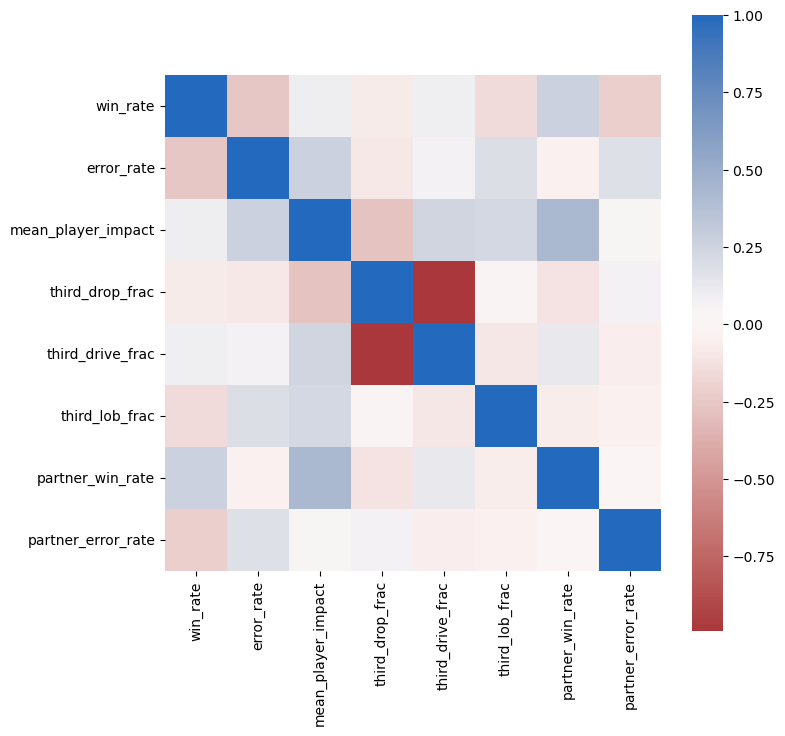

In [104]:
corr = summary_df.corr()
plt.subplots(figsize=(8, 8))
sns.heatmap(corr, cmap="vlag_r", square=True)
plt.savefig("../figures/correlations.png")
plt.show()

In [94]:
#Correlation between win rate and other stats
summary_df.corr().sort_values('win_rate', ascending=False)['win_rate']

win_rate              1.000000
partner_win_rate      0.267985
mean_player_impact    0.126942
third_drive_frac      0.096034
third_drop_frac      -0.077191
third_lob_frac       -0.152468
partner_error_rate   -0.220466
error_rate           -0.259778
Name: win_rate, dtype: float64

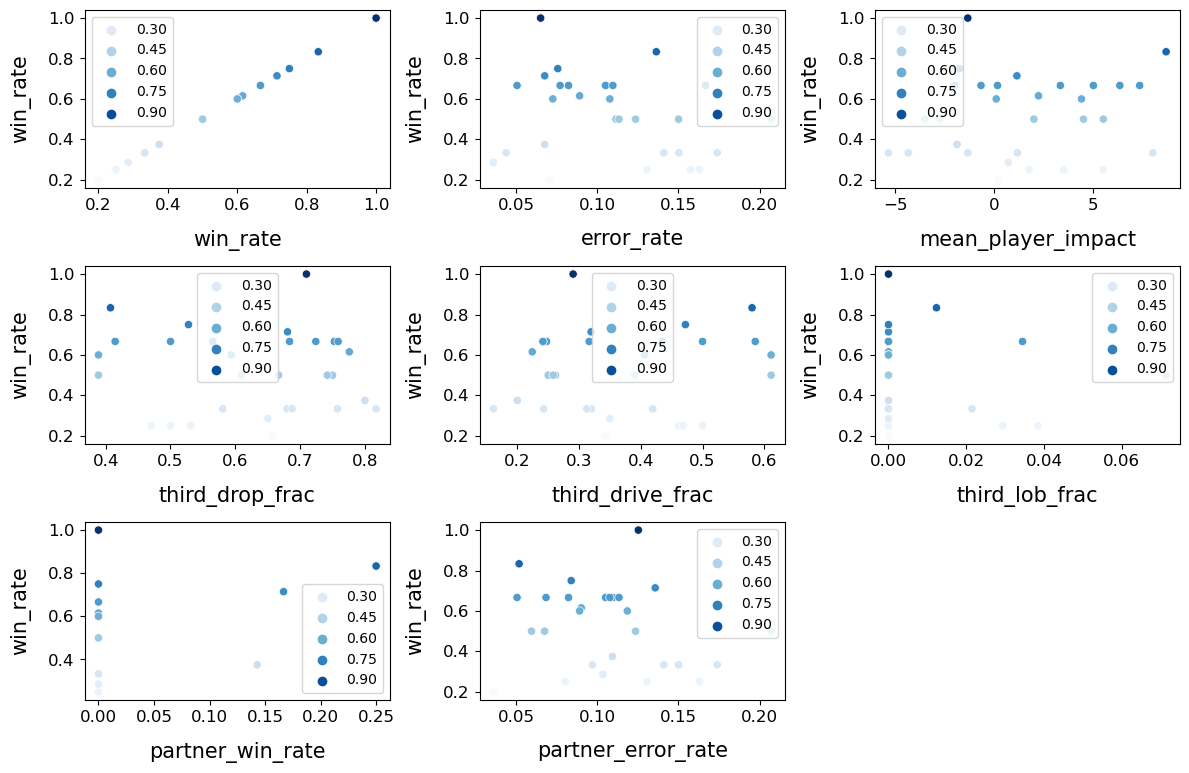

In [95]:
# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in summary_df.columns:
    if summary_df[i].dtype in numeric_dtypes:
        if i in ['name']:
            pass
        else:
            numeric.append(i)    
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 20))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(summary_df[numeric]), 1):
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='win_rate', hue='win_rate', palette='Blues', data=summary_df)
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('win_rate', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.tight_layout()
plt.show()

In [ ]:
#Todo: Add partner win rate